In [1]:
import torch
import toy

ds = toy.ToyDataset()
tn = toy.ToyTokenizer()
print(ds[30])
print(tn.tokenize(ds[30]))
print(tn.detokenize(tn.tokenize(ds[30])))

3 + 0 = 3
[6, 1, 3, 2, 6, 0]
3 + 0 = 3


In [2]:
def get_dataloader():
    dataset = toy.ToyDataset(transform=toy.TokenizerTransform())
    return torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

dl = get_dataloader()
for b in dl:
    break

In [3]:
from llama import ModelArgs, Decoder, SelfAttention

device = 'mps'
args = ModelArgs(max_batch_size=128, max_seq_len=6, dim=32, n_layers=4, n_heads=8, device=device, vocab_size=22)
net = Decoder(args)

net = net.to(device)
b = b.to(device)

In [4]:
# y = net(b, 0)
x = torch.rand(128, 6, 32).to(device)
ats = SelfAttention(args)
ats = ats.to(device)
y = ats(x, 0)


In [9]:
# Example of target with class indices
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = torch.nn.functional.cross_entropy(input, target)
loss.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# loss = F.cross_entropy(input, target)
# loss.backward()

In [10]:
print(input.shape, target.shape)

torch.Size([3, 5]) torch.Size([3])


In [173]:
rope = RoPE(args)
data = rope.freqs_complex.squeeze(0).squeeze(1)

In [175]:
data

tensor([[ 1.0000+0.0000j,  1.0000+0.0000j],
        [ 0.5403+0.8415j,  0.9999+0.0100j],
        [-0.4161+0.9093j,  0.9998+0.0200j],
        ...,
        [ 0.9981+0.0620j,  0.3687-0.9295j],
        [ 0.4871+0.8733j,  0.3780-0.9258j],
        [-0.4717+0.8818j,  0.3872-0.9220j]])

In [181]:
data.real.shape

torch.Size([512, 2])

In [202]:
import matplotlib.pyplot as plt

def vis_rope(len=20, index=0):
    real_parts = data[:len, index].real
    imag_parts = data[:len, index].imag
    
    plt.figure(figsize=(8, 8))
    plt.plot(real_parts, imag_parts, linewidth=1)
    
    plt.scatter(real_parts[0], imag_parts[0], color='red', s=100, label='Start')
    plt.scatter(real_parts[-1], imag_parts[-1], color='blue', s=100, label='End')
    
    plt.xlabel("Real part")
    plt.ylabel("Imaginary part")
    plt.title("Complex plane visualization")
    plt.grid(True)
    plt.show()

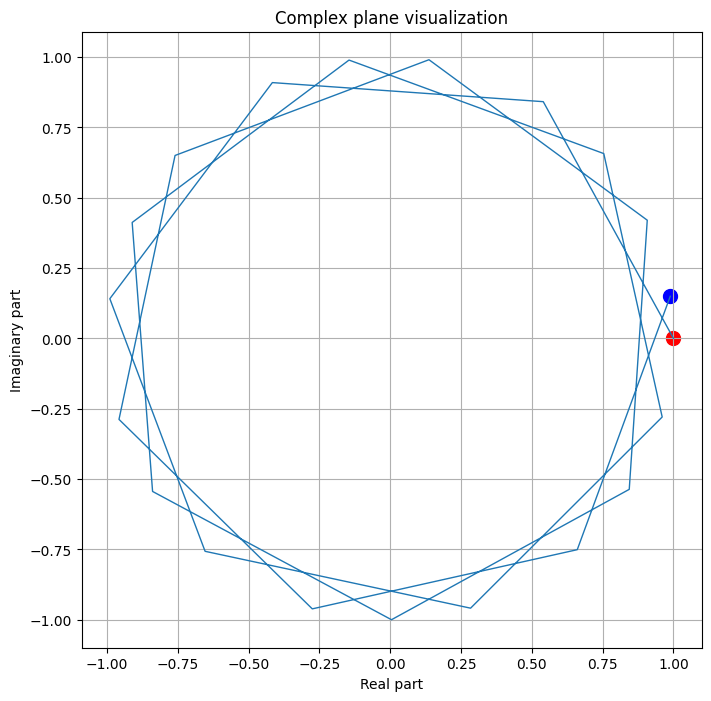

In [203]:
vis_rope(20, 0)

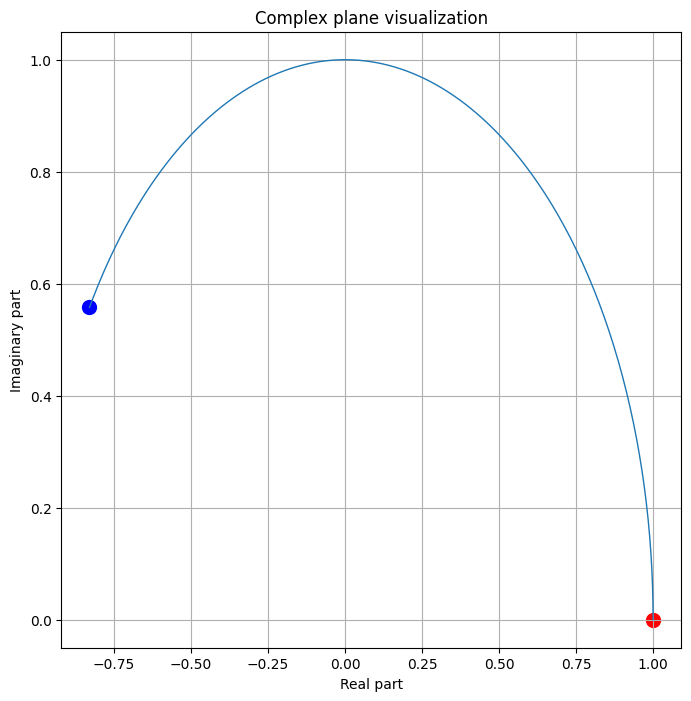

In [223]:
vis_rope(256, 1)

In [208]:
seq_len = 256
dim_per_head = 4
theta = 10000

theta_numerator = torch.arange(0, dim_per_head, 2).float()
# Shape: (dim_per_head / 2)
theta = 1.0 / (theta ** (theta_numerator / dim_per_head)) # (Dim / 2)
# Construct the positions (the "m" parameter)
# Shape: (Seq_Len)
m = torch.arange(seq_len)
# Multiply each theta by each position using the outer product.
# Shape: (Seq_Len) outer_product* (dim_per_head / 2) -> (Seq_Len, dim_per_head / 2)
freqs = torch.outer(m, theta).float()
# We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
# (Seq_Len, dim_per_head / 2) -> (Seq_Len, dim_per_head / 2)
freqs_complex = torch.polar(torch.ones_like(freqs), freqs)

torch.Size([256, 2]) torch.Size([256, 2])


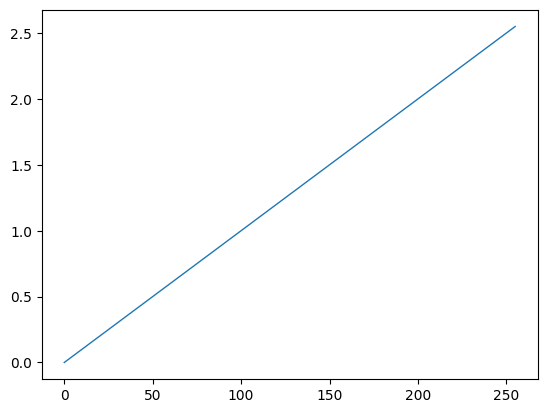

In [224]:
print(freqs.shape, freqs_complex.shape)
plt.plot(freqs[:,0], freqs[:,1], linewidth=1)

In [3]:
from llama import Decoder, ModelArgs
from toy import ToyTokenizer
import torch

device = 'mps'
model_path = 'toy_llama.pth'
net = Decoder(ModelArgs(max_batch_size=1, max_seq_len=6, dim=32, n_layers=4, n_heads=8, device=device, vocab_size=22))
net.load_state_dict(torch.load(model_path))
tokenizer = ToyTokenizer()

net.eval()
with torch.no_grad():
    text = '1 + 8 = '
    tokens = tokenizer.tokenize(text)
    tokens.append(tokenizer.eos)
    x = torch.tensor(tokens, dtype=torch.int)
    print(x)
    y = net(x)
    print(y)
    y = y.argmax(dim=1)
    print(y)
    print(tokenizer.detokenize(y))

tensor([ 4,  1, 11,  2,  0,  0], dtype=torch.int32)
tensor([[-2.8597e-01,  5.1335e+00,  4.7327e-01,  1.3427e-01, -1.1689e+00,
         -7.0267e-01, -8.4378e-01,  1.0992e-01, -1.2454e+00, -1.2128e+00,
         -1.0938e+00, -4.7421e-01, -1.5529e+00, -1.1931e+00, -2.1480e-01,
         -4.2327e-01, -6.7333e-01, -8.9633e-01, -1.1880e+00, -1.0944e+00,
         -5.8150e-01, -1.4063e-01],
        [-5.8308e-02,  3.0928e+00, -3.5826e-01,  1.9414e+00,  5.9017e-01,
          8.8235e-01,  8.0035e-01,  1.4022e+00,  7.2239e-01,  7.6591e-01,
          2.7565e-01,  9.2028e-01,  3.0130e-01, -1.2305e+00, -1.9490e+00,
         -1.1458e+00, -1.1889e+00, -1.5966e+00, -1.8679e+00, -1.8787e+00,
         -1.3578e+00, -1.1408e+00],
        [-3.3852e-01,  5.0157e+00,  1.3990e+00,  1.6022e-01, -1.2602e+00,
         -9.7750e-01, -9.0582e-01, -3.6655e-01, -1.5542e+00, -1.2448e+00,
         -1.6797e+00, -6.5621e-01, -1.7130e+00, -1.0978e+00, -3.7373e-01,
         -7.8091e-01, -7.7638e-01, -9.4307e-01, -1.2754e+00, -